In [2]:
import tensorflow as tf
# check the version
tf.__version__

'2.19.0'

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
DATA_DIR     = "data"                 
IMG_SIZE     = (224, 224)
BATCH_SIZE   = 32
VAL_SPLIT    = 0.20                 
TEST_SPLIT   = 0.20                  
SEED         = 123

AUTOTUNE     = tf.data.AUTOTUNE




In [6]:
# 1) Reserve out BOTH val+test together
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT + TEST_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
)

# 2) Temp set = val+test combined
temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT + TEST_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
)

CLASS_NAMES = train_ds.class_names
print("Detected folder order:", CLASS_NAMES)

# 3) Slice temp_ds → val_ds & test_ds
total_temp = tf.data.experimental.cardinality(temp_ds).numpy()
val_batches  = int(total_temp * VAL_SPLIT / (VAL_SPLIT + TEST_SPLIT))
test_batches = total_temp - val_batches

val_ds  = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

# 4) Cache / prefetch
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

print("Batches → train:", tf.data.experimental.cardinality(train_ds).numpy(),
      " val:", tf.data.experimental.cardinality(val_ds).numpy(),
      " test:", tf.data.experimental.cardinality(test_ds).numpy())


Found 1819 files belonging to 2 classes.
Using 1092 files for training.
Found 1819 files belonging to 2 classes.
Using 727 files for validation.
Detected folder order: ['metal', 'paper']
Batches → train: 35  val: 11  test: 12


In [7]:
for images, labels in train_ds.take(1):
    print("Image shape:", images.shape)
    print("Pixel value range: min =", tf.reduce_min(images).numpy(),
          "max =", tf.reduce_max(images).numpy())
    break
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    break


Image shape: (32, 224, 224, 3)
Pixel value range: min = 0.0 max = 255.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [101.32142..250.5307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13.113861..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.41327932..253.00003].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.88776].


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input


# Load pretrained base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model


In [9]:
inputs  = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

transfer_model = Model(inputs, outputs)


In [10]:
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
checkpoint = ModelCheckpoint('best_transfer_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


In [12]:
_transfer_raw = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT + TEST_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
)

_temp_raw = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT + TEST_SPLIT,
    subset="validation",               # holds (val + test) for now
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
)

# 2) Slice temp → val & test
total_temp = tf.data.experimental.cardinality(_temp_raw).numpy()
val_batches  = int(total_temp * VAL_SPLIT / (VAL_SPLIT + TEST_SPLIT))
test_batches = total_temp - val_batches

_val_raw   = _temp_raw.take(val_batches)
_test_raw  = _temp_raw.skip(val_batches)

# 3) Normalisation layer
norm = tf.keras.layers.Rescaling(1./255)
transfer_dataset = _transfer_raw.map(lambda x, y: (norm(x), y))
val_dataset      = _val_raw.map(lambda x, y: (norm(x), y))
test_dataset     = _test_raw.map(lambda x, y: (norm(x), y))

# 4) Cache & prefetch
transfer_dataset = transfer_dataset.cache().prefetch(AUTOTUNE)
val_dataset      = val_dataset.cache().prefetch(AUTOTUNE)
test_dataset     = test_dataset.cache().prefetch(AUTOTUNE)

# 5) Class names + sanity check
CLASS_NAMES = _transfer_raw.class_names
print("Detected folder order:", CLASS_NAMES)
print("Batches → train:", tf.data.experimental.cardinality(transfer_dataset).numpy(),
      " val:", tf.data.experimental.cardinality(val_dataset).numpy(),
      " test:", tf.data.experimental.cardinality(test_dataset).numpy())

Found 1819 files belonging to 2 classes.
Using 1092 files for training.
Found 1819 files belonging to 2 classes.
Using 727 files for validation.
Detected folder order: ['metal', 'paper']
Batches → train: 35  val: 11  test: 12


In [13]:
history = transfer_model.fit(
    transfer_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7682 - loss: 0.4920
Epoch 1: val_loss improved from inf to 0.12345, saving model to best_transfer_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 297ms/step - accuracy: 0.7711 - loss: 0.4867 - val_accuracy: 0.9489 - val_loss: 0.1234
Epoch 2/30
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9552 - loss: 0.1270
Epoch 2: val_loss improved from 0.12345 to 0.09536, saving model to best_transfer_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9553 - loss: 0.1263 - val_accuracy: 0.9716 - val_loss: 0.0954
Epoch 3/30
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9734 - loss: 0.0716
Epoch 3: val_loss improved from 0.09536 to 0.08683, saving model to best_transfer_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9735 - loss: 0.0714 - val_accuracy: 0.9744 - val_loss: 0.0868
Epoch 4/30
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9751 - loss: 0.0767
Epoch 4: val_loss improved from 0.08683 to 0.08486, saving model to best_transfer_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9750 - loss: 0.0764 - val_accuracy: 0.9744 - val_loss: 0.0849
Epoch 5/30
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9852 - loss: 0.0480
Epoch 5: val_loss did not improve from 0.08486
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9852 - loss: 0.0478 - val_accuracy: 0.9801 - val_loss: 0.0889
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9859 - loss: 0.0414
Epoch 6: val_loss did not improve from 0.08486
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.9860 - loss: 0.0413 - val_accuracy: 0.9830 - val_loss: 0.0915
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9935 - loss: 0.0321
Epoch 7: val_loss did not improve from 0.08486
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9934 - loss: 0.0323 - val_accuracy: 0.9744 - val_loss: 0.1052
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9816 - loss: 0.0469
Epoch 8: val_loss did not improve from 0.08486


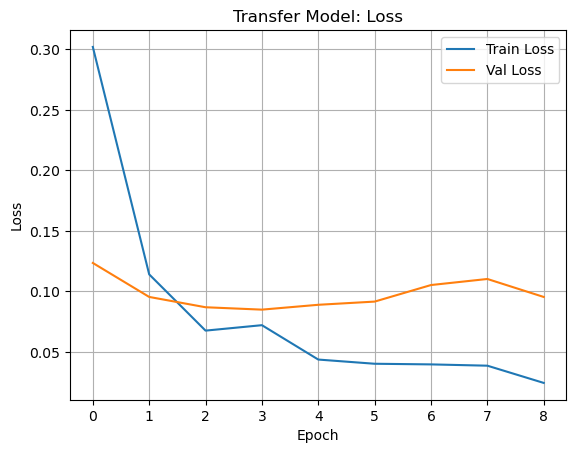

In [15]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Transfer Model: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



In [14]:
test_loss, test_acc = transfer_model.evaluate(test_dataset)
print(f"Transfer Model Accuracy: {test_acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9903 - loss: 0.0429
Transfer Model Accuracy: 0.9787


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


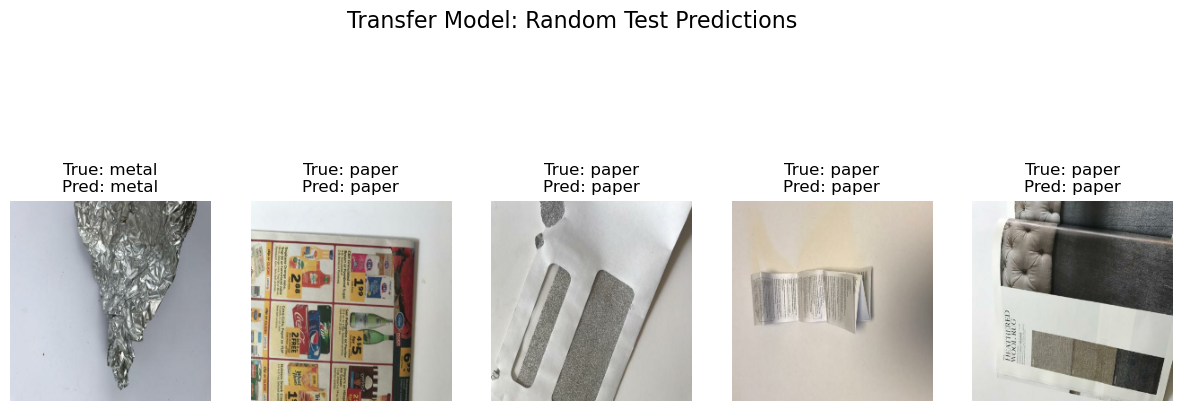

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# Get one batch from test_dataset
for images, labels in test_dataset.take(1):
    preds = np.argmax(transfer_model.predict(images), axis=1)
    images = images.numpy()
    labels = labels.numpy()
    break

# Show 5 random predictions
plt.figure(figsize=(15, 6))
for i in range(5):
    idx = np.random.randint(0, len(images))
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {CLASS_NAMES[labels[idx]]}\nPred: {CLASS_NAMES[preds[idx]]}")
    plt.axis("off")
plt.suptitle("Transfer Model: Random Test Predictions", fontsize=16)
plt.show()

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('best_transfer_model.h5')

# Class names
CLASS_NAMES = ['metal', 'paper']

# Camera settings
cap = cv2.VideoCapture(0)
box_size = 224  # Should match your model input
frame_center = (320, 240)  # Adjust if your camera resolution is different

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Calculate ROI coordinates
    x1 = frame_center[0] - box_size // 2
    y1 = frame_center[1] - box_size // 2
    x2 = frame_center[0] + box_size // 2
    y2 = frame_center[1] + box_size // 2

    # Draw rectangle on frame
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    roi = frame[y1:y2, x1:x2]

    # Only predict if ROI is correct size
    if roi.shape[0] == box_size and roi.shape[1] == box_size:
        img = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)
        preds = model.predict(img)
        pred_idx = np.argmax(preds)
        confidence = preds[0][pred_idx]

        if confidence > 0.7:
            label = CLASS_NAMES[pred_idx]
        else:
            label = "no material found"

        cv2.putText(frame, f"{label} ({confidence:.2f})", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Material Detector', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━